# Questão 2 - Gabarito

Gabarito da questão 2 do simulado da prova disponível em: 

[https://github.com/mirwox/r20sim/blob/master/enunciado.md](https://github.com/mirwox/r20sim/blob/master/enunciado.md)

**Nota:** Esta questão analisa apenas uma imagem estática. Portanto pode ser feito tranquilamente num Jupyter Notebook. Trata-se de uma questão apenas de Python/OpenCV, onde o ROS não é utilizado.

Caso fosse uma questão de processamento de vídeo, seria interessante usar o exemplo `videoplay.py`. E se fosse uma questão de ROS precisaria ser um exemplo em que há subscrição de um tópico de imagem.

In [11]:
import cv2
import os
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

print("Versao OpenCV ", cv2.__version__)

print("Diretorio de trabalho (tenha certeza de onde está trabalhando): ", os.getcwd())

Versao OpenCV  4.2.0
Diretorio de trabalho (tenha certeza de onde está trabalhando):  /Users/mirwox/Dropbox/Insper/2016/Robotics/src/r20sim/p1_opencv


In [2]:
!ls

Q2_sim_gabarito.ipynb prova_laranjas.png    webcam.py
auxiliar.py           videoplay.py
escala.png            videoplay_canny.py


In [3]:
escala_filename = "escala.png"
laranjas_filename = "prova_laranjas.png"

## Leitura

In [4]:
escala_bgr = cv2.imread(escala_filename)
laranjas_bgr = cv2.imread(laranjas_filename)

Conversão para formatos úteis:

In [6]:
def converte_rgb_hsv(bgr):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    return rgb, hsv

escala_rgb, escala_hsv = converte_rgb_hsv(escala_bgr)
laranjas_rgb, laranjas_hsv = converte_rgb_hsv(laranjas_bgr)

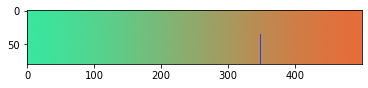

In [7]:
plt.imshow(escala_rgb)

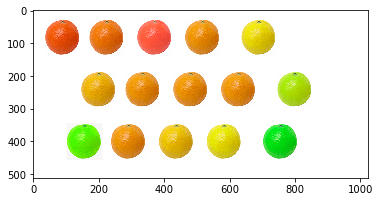

In [8]:
plt.imshow(laranjas_rgb)

Vamos usar o color picker do Gimp para descobrir os valores da componente H do modelo HSV. Se você estiver no Linux, para instalar o Gimp faça (tirando a hashtag):

In [10]:
# ! sudo apt install gimp

## Cores do color picker

HSV do Gimp na parte marcada na escala pela linha azul: 33, 56, 73

HSV no final da escala laranja à direita: 18, 75, 90

HSV no começo da escala (verde): 155,75,90


In [14]:
limite = (33, 56, 73)
direita_laranja = (18,75,90)
esquerda_verde = (155,75,90)

## Convertendo cores do color picker em cores da OpenCV:

Precisamos converter o HSV do Gimp, que usa as escalas $360^{\circ}, 100\%, 100\%$ para a escala da OpenCV, que usa $180, 255,255$

In [15]:
def hsv_gimp_to_cv2(gimp):
    h = int(gimp[0]/2.0)
    s = int(gimp[1]*2.55)
    v = int(gimp[2]*2.55)
    cv2_hsv = np.array([ h, s, v], dtype=np.uint8)
    return cv2_hsv

In [18]:
limite_cv2 = hsv_gimp_to_cv2(limite)
direita_laranja_cv2 = hsv_gimp_to_cv2(direita_laranja)
esquerda_verde_cv2 = hsv_gimp_to_cv2(esquerda_verde)


Checando os valores:

In [28]:
print(esquerda_verde_cv2, limite_cv2, direita_laranja_cv2)

[ 77 191 229] [ 16 142 186] [  9 191 229]


## Solução exemplo - usar somente a componente H

O enunciado dá a entender que a filtragem poderia ser realizada usando somente a componente $Hue$. Vamos seguir esta estratégia e verificar.

Separando somente a componente $H$:

In [20]:
laranjas_h = laranjas_hsv[:,:,0]

Lembrando que `laranjas_h` é uma imagem de somente 1 canal:

In [34]:
laranjas_h.shape

(512, 1024)

Verificando a componente H:

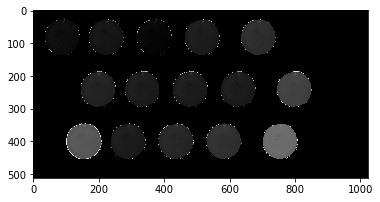

In [42]:
plt.imshow(laranjas_h, Cmap="Greys_r", vmin=0, vmax=180) # o vmax de 180 foi adotado porque a H só vai até este limite

Vamos isolar o valor $H$ das componentes:

In [29]:
h_lim = limite_cv2[0]

In [43]:
h_lim

16

In [30]:
h_verde = esquerda_verde_cv2[0]

In [36]:
h_verde

77

In [31]:
h_laranja = direita_laranja_cv2[0]

In [44]:
h_laranja

9

Criação da máscara

In [45]:
mask_h = cv2.inRange(laranjas_h, int(h_laranja), int(h_lim))

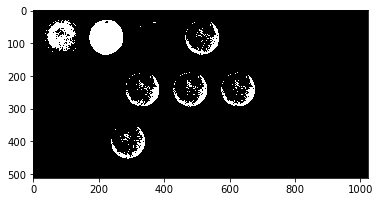

In [46]:
plt.imshow(mask_h, Cmap="Greys_r", vmin=0, vmax=255)

Teste: *qualquer* $H$

Note que qualquer valor **abaixo** do limite resulta numa toranja madura, independentemente da faixa desejada para o laranja ser entre $9$ e $16$

In [52]:
mask_alt = cv2.inRange(laranjas_h, 1, int(h_lim))

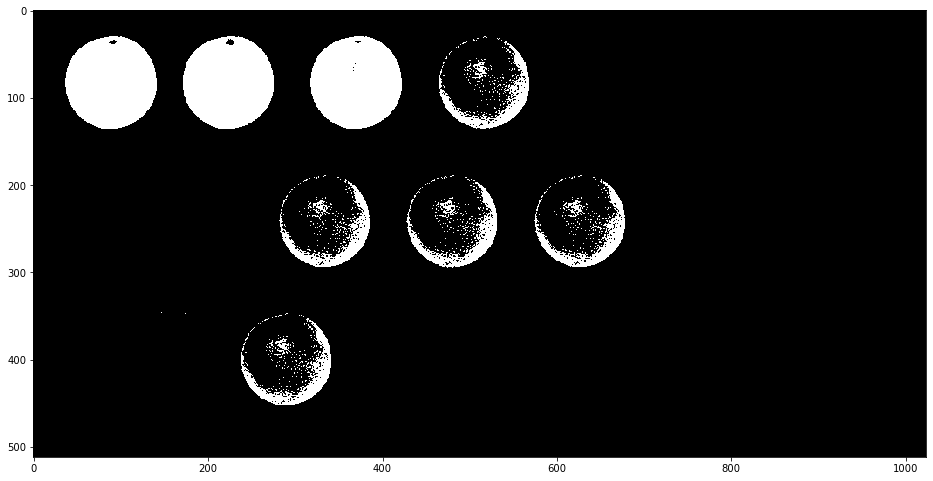

In [56]:
plt.figure(figsize=(16, 20))
plt.imshow(mask_alt, Cmap="Greys_r", vmin=0, vmax=255)

A partir da figura acima, podemos ver que há 8 laranjas, mas precisamos fazer com que o código chegue a esta conclusão. O maior desafio são as toranjas que têm sua segmentação com "ruído". 

Mas **já** poderia ser o suficiente para transformada de $Hough$

In [58]:
cv2.imwrite("mascara_filtragem.png", mask_alt)

True

In [60]:
! open mascara_filtragem.png

In [61]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

In [62]:
bordas = auto_canny(mask_alt)

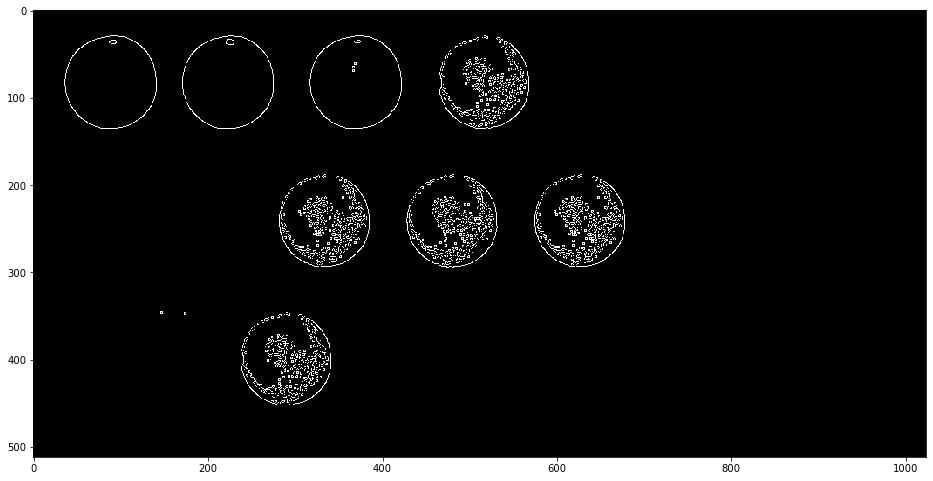

In [64]:
plt.figure(figsize=(16, 20))
plt.imshow(bordas, cmap="Greys_r", vmin=0, vmax=255)

Vamos agora aplicar a transformada de $Hough$, ajustando acumulador e tamanho dos círculos. conforme visto nos exemplos da aula 2 em [https://github.com/Insper/robot20/blob/master/aula02/Atividade2_Exemplos.ipynb](https://github.com/Insper/robot20/blob/master/aula02/Atividade2_Exemplos.ipynb)

In [103]:
circles=cv2.HoughCircles(image=bordas,method=cv2.HOUGH_GRADIENT,dp=2,minDist=15,param1=50,param2=100,minRadius=40,maxRadius=130)
bordas_rgb = cv2.cvtColor(bordas, cv2.COLOR_GRAY2RGB)

output =  bordas_rgb

if circles is not None:        
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(output,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(output,(i[0],i[1]),2,(0,0,255),3)

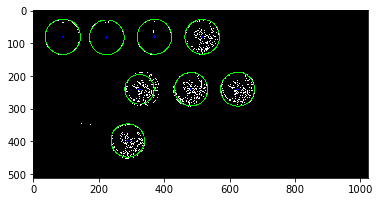

In [104]:
plt.imshow(output, vmin=0, vmax=255, cmap="Greys_r")

Note que *é necessário que seu código emita uma resposta definitiva*, portanto aqui está:

In [107]:
print("O número de círculos é ", circles.shape[1])

O número de círculos é  8


# Outras possíveis soluções

Também é possível resolver:
* Fazendo o `inRange` usando as 3 componentes do HSV
* Limpando a imagem com morfologia, *depois* fazendo os contornos e depois contando os contornos. Ajsutando a morfologia até deixar os contornos adequados
